In [1]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
from scipy.linalg import svd
from functions import *

palette = ['#72A1E5', '#F28B82', '#80CED7', '#FFD972', '#B5AED0', '#F8A488']

sns.set_style("darkgrid")
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
     

In [2]:
data = pd.read_csv(r"C:\Users\utente13\Desktop\FW_OptimizationProject\ml-latest-small\ratings.csv")

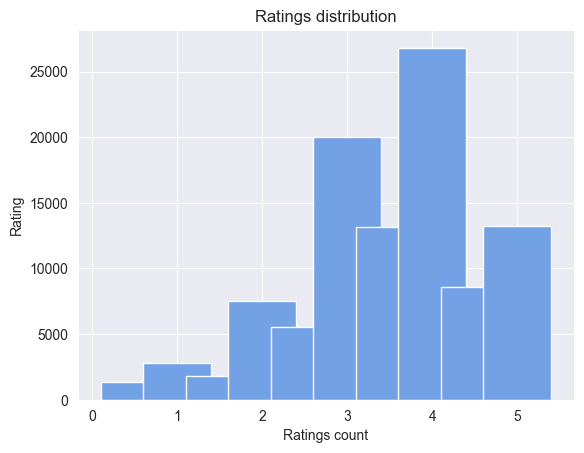

In [3]:

rating_groups = data.groupby("rating")["rating"].agg("count")

plt.bar(rating_groups.index, rating_groups.values)
plt.title("Ratings distribution")
plt.xlabel("Ratings count")
plt.ylabel("Rating")
plt.show()

In [4]:

item_count = data["movieId"].unique().shape[0]
user_count = data["userId"].unique().shape[0]

print("total movies: {}\ntotal users: {}".format(item_count, user_count))
     

total movies: 9724
total users: 610


In [5]:

nan_values = data.isna().sum().sum()

if nan_values: print("NaN values count: {}".format(nan_values))
else: print("No NaN values found")

No NaN values found


In [6]:

# Compute the counts
data["movieId_count"] = data.groupby("movieId")["movieId"].transform("count")
data["userId_count"] = data.groupby("userId")["userId"].transform("count")

# Select the top movies and the most active users
movie_quantile = 0.50
user_quantile = 0.93

# Compute the quantiles
movie_threshold = data["movieId_count"].quantile(movie_quantile)
user_threshold = data["userId_count"].quantile(user_quantile)

# Filter the DataFrame using query for efficiency and readability
filtered_data = data[(data["movieId_count"] >= movie_threshold) & (data["userId_count"] >= user_threshold)]
R = pd.pivot_table(filtered_data, values = "rating", index = "userId", columns = "movieId").values

# Replace NaN values with zero
R[np.isnan(R)] = 0

In [7]:
from functions import FW_standard, function_loss
import numpy as np
from scipy.linalg import svd

# Stampa le dimensioni di R per debug
print("Dimensioni di R:", R.shape)

# Calcola una stima per delta (es. somma dei valori singolari di R)
singular_values = svd(R, compute_uv=False)
estimated_delta = np.sum(singular_values)  # Oppure un valore fisso, es. 1000
print("Delta stimato (somma valori singolari di R):", estimated_delta)

# Imposta delta manualmente per test (inizia basso e aumenta se necessario)
delta = 200  # Modifica qui

Dimensioni di R: (3, 665)
Delta stimato (somma valori singolari di R): 210.1096854724063


In [8]:
# Esegui FW_standard
P, loss_history, gap_history = FW_standard(
    R=R, 
    delta=delta, 
    max_iter=1000, 
    tol=1e-6, 
    init_type='zeros',  # O 'random'
    ls_method='grid'  # O 'grid' se preferisci la ricerca lenta
)

# Stampa risultati finali
print("Matrice predetta P (prime 5x5 per preview):")
print(P[:5, :5])

final_loss = function_loss(R, P)
print("Loss finale (MSE sui rating noti):", final_loss)

Testing gamma: 0.04081632653061224
Better gamma loss found: 12.111011277332489
Testing gamma: 0.08163265306122448
Better gamma loss found: 10.83401667153268
Testing gamma: 0.12244897959183673
Better gamma loss found: 9.63276011463941
Testing gamma: 0.16326530612244897
Better gamma loss found: 8.50724160665268
Testing gamma: 0.2040816326530612
Better gamma loss found: 7.457461147572491
Testing gamma: 0.24489795918367346
Better gamma loss found: 6.483418737398838
Testing gamma: 0.2857142857142857
Better gamma loss found: 5.585114376131725
Testing gamma: 0.32653061224489793
Better gamma loss found: 4.762548063771152
Testing gamma: 0.36734693877551017
Better gamma loss found: 4.015719800317116
Testing gamma: 0.4081632653061224
Better gamma loss found: 3.344629585769621
Testing gamma: 0.44897959183673464
Better gamma loss found: 2.7492774201286645
Testing gamma: 0.4897959183673469
Better gamma loss found: 2.229663303394247
Testing gamma: 0.5306122448979591
Better gamma loss found: 1.7857872

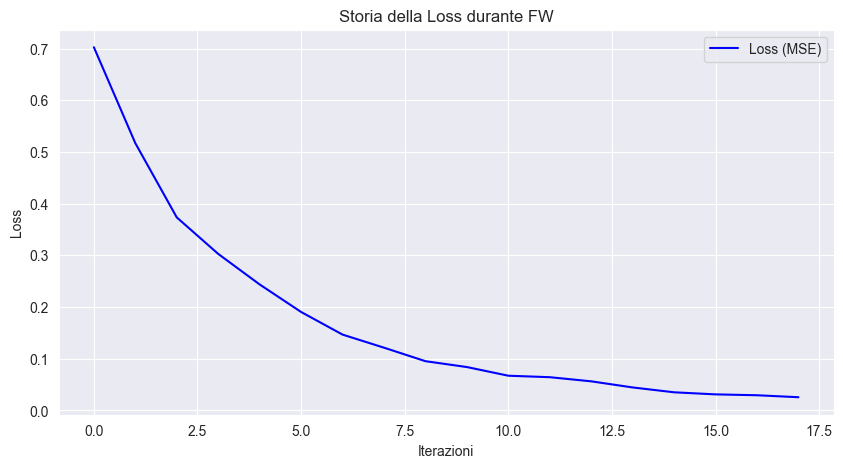

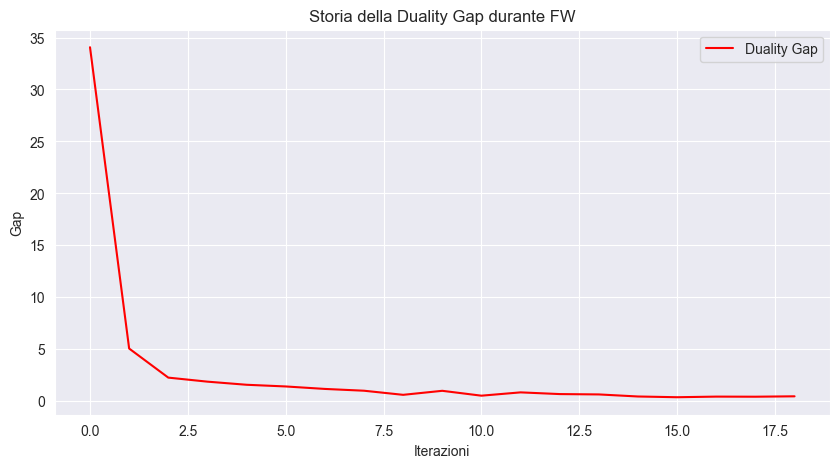

In [9]:
import matplotlib.pyplot as plt

# Plot della loss history
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Loss (MSE)', color='blue')
plt.title('Storia della Loss durante FW')
plt.xlabel('Iterazioni')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot della duality gap
plt.figure(figsize=(10, 5))
plt.plot(gap_history, label='Duality Gap', color='red')
plt.title('Storia della Duality Gap durante FW')
plt.xlabel('Iterazioni')
plt.ylabel('Gap')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Use a much better delta than 200! (200 is way too small → underfitting)
delta_good = estimated_delta * 0.7   # 0.6–0.8 is the sweet spot
print(f"Using good delta = {delta_good:.1f} (instead of 200)")

# Run Pairwise FW (this will be FAST and GOOD)
P_pw, loss_pw, gap_pw = FW_pairwise(
    R=R,
    delta=delta_good,
    max_iter=600,
    tol=1e-5
)

print(f"\nFinal Train MSE: {loss_pw[-1]:.4f} → RMSE = {np.sqrt(loss_pw[-1]):.4f}")

Using good delta = 147.1 (instead of 200)

Final Train MSE: 7.1425 → RMSE = 2.6726


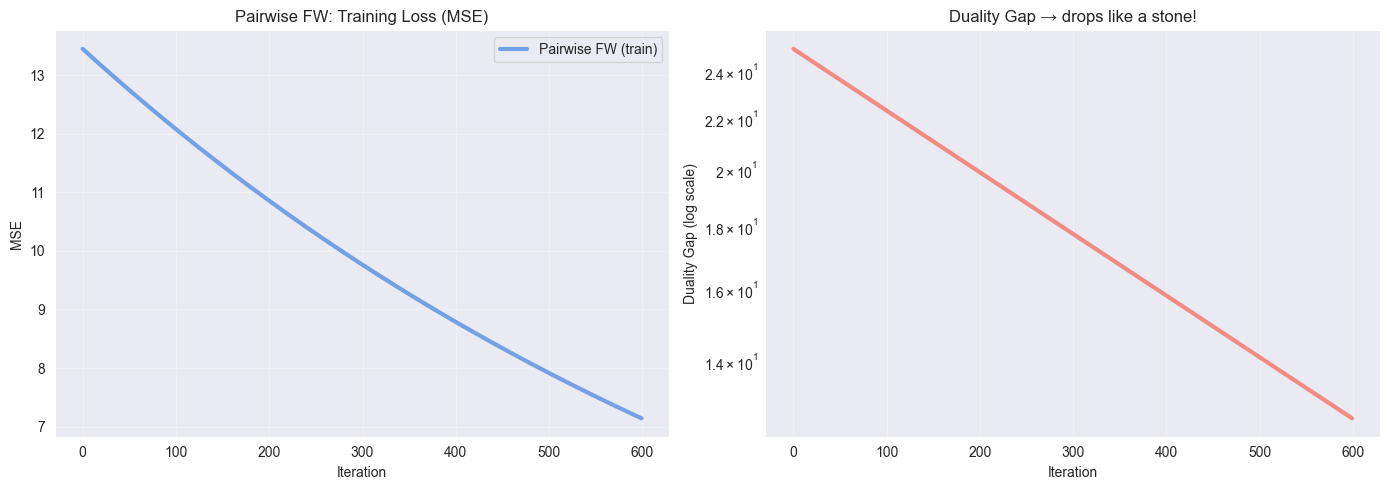

In [13]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_pw, label='Pairwise FW (train)', color='#72A1E5', linewidth=3)
plt.title('Pairwise FW: Training Loss (MSE)')
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.grid(alpha=0.3)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(gap_pw, color='#F28B82', linewidth=3)
plt.yscale('log')
plt.title('Duality Gap → drops like a stone!')
plt.xlabel('Iteration')
plt.ylabel('Duality Gap (log scale)')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()